In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel

from statsmodels.tsa.arima.model import ARIMA
import sklearn.metrics as skmetrics #For evaluation metrics
from sklearn.metrics import mean_absolute_error

import warnings                               
warnings.filterwarnings('ignore')

#### 1. In this question, you will acquainted with fitting data with SARIMA

(a) Split the data into history=before 2015-11-30 (included), and the rest as a test. We will first focus on using history to select and train a model:

In [57]:
df = pd.read_csv('./data/beer.csv',index_col=0, parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date'])
split = pd.to_datetime('2015-11-30')
history = df[df['Date'] <= split]
test = df[df['Date'] > split]
history = history.set_index('Date')
test = test.set_index('Date')

(b) Use the plots of the original beer consumption in history, combined with ADF test if you wish, to determine if there’s trend and/or seasonality in the data.

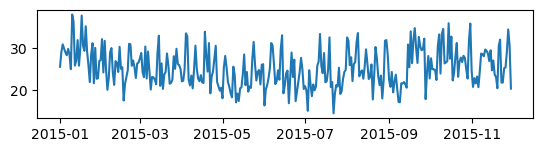

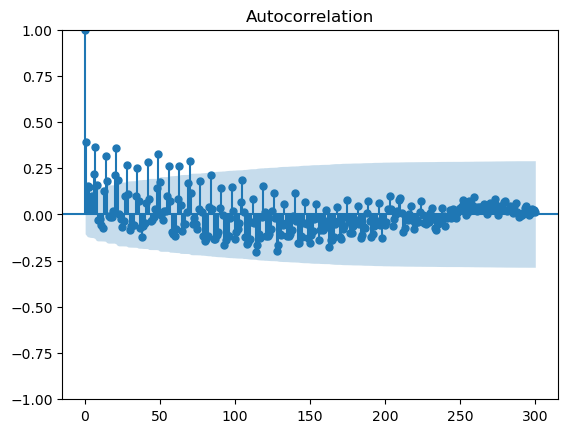

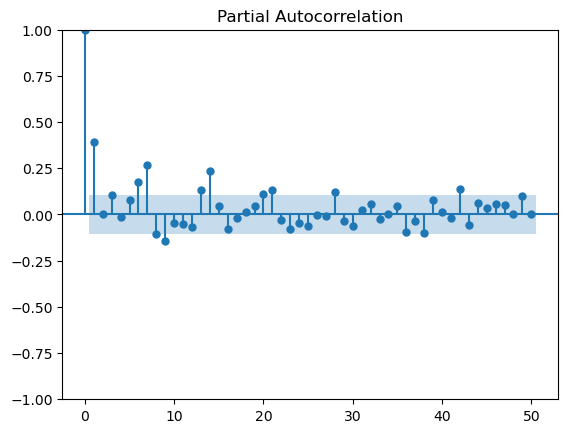

In [42]:
plt.subplot(3,1,1)

plt.plot(history['Beer_Consumption'])
plt.show()

plot_acf(history['Beer_Consumption'],lags=300)
plot_pacf(history['Beer_Consumption'],lags=50)
plt.show()

In [33]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [44]:
adf_test(history['Beer_Consumption'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.394400
p-value                          0.011151
#Lags Used                      13.000000
Number of Observations Used    320.000000
Critical Value (1%)             -3.450952
Critical Value (5%)             -2.870615
Critical Value (10%)            -2.571605
dtype: float64


It seems stationary.

(c) Use a combination of plots, differencing, and/or ADF test to give a range of d, D and a number for seasonal freq m for your grid search.

In [45]:
def diff(data, interval):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

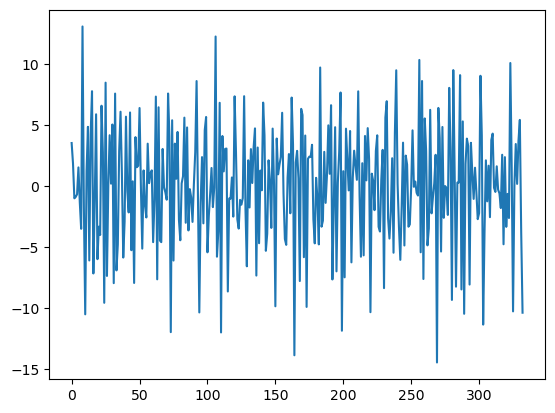

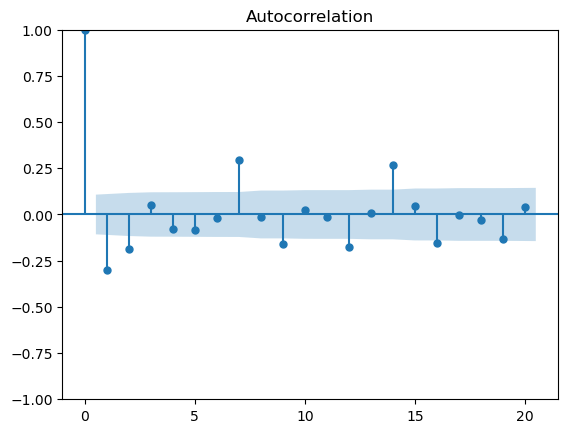

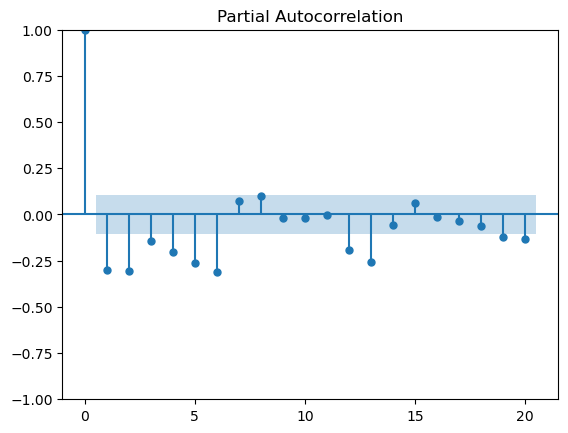

Results of Augmented Dickey-Fuller Test:
Test Statistic                -9.426212e+00
p-value                        5.338160e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.200000e+02
Critical Value (1%)           -3.450952e+00
Critical Value (5%)           -2.870615e+00
Critical Value (10%)          -2.571605e+00
dtype: float64


In [47]:
detrend_df = diff(history['Beer_Consumption'], 1)
plt.plot(detrend_df)
plot_acf(detrend_df ,lags=20) 
plot_pacf(detrend_df ,lags=20) 
plt.show()
adf_test(detrend_df)

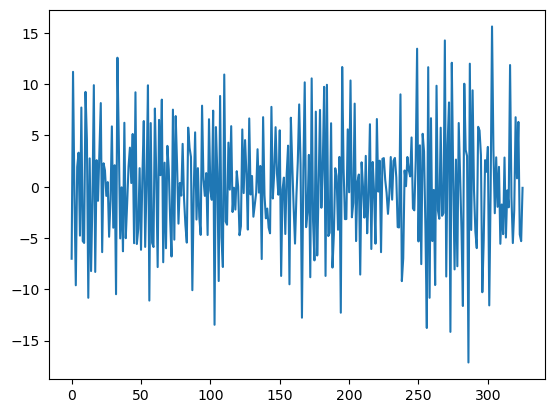

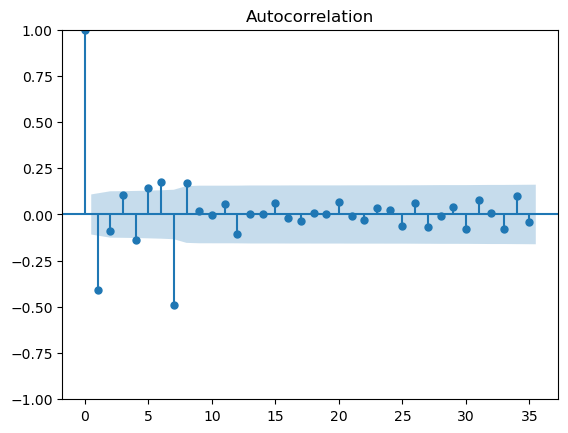

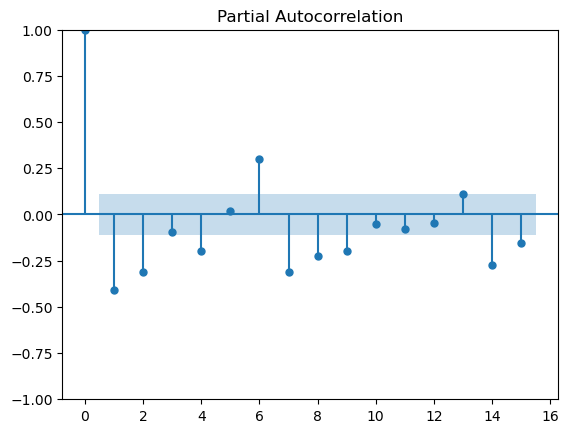

Results of Augmented Dickey-Fuller Test:
Test Statistic                -8.879011e+00
p-value                        1.333613e-14
#Lags Used                     1.700000e+01
Number of Observations Used    3.080000e+02
Critical Value (1%)           -3.451761e+00
Critical Value (5%)           -2.870970e+00
Critical Value (10%)          -2.571794e+00
dtype: float64


In [48]:
deseason_df = diff(detrend_df, 7)
plt.plot(deseason_df)
plot_acf(deseason_df ,lags=35) 
plot_pacf(deseason_df ,lags=15) 
plt.show()
adf_test(deseason_df)

I will choose d=[1,2], D=1, m=7

(d) Based on your forecasting goal: reach a good average performance on predicting the length of the test set, design a 5-fold cross-validation method with MAE using the historical data. Write Python functions based on this design, and select a model from SARIMA((p,d,q)*(P,D,Q,m)). Report the model selected and validation avg-MAE.

In [49]:
def evaluate_models_cv(dataset, val_len, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K=5
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size = val_len
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(0,5):
                                train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = ARIMA(train, order=trend_order, seasonal_order=seasonal_order) #each step: rolling one step forward to update the train se
                                model_fit = model.fit()
                                predictions=model_fit.forecast(validation_size)
                                rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                            rmse_avg=rmse/5
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('ARIMA%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))

In [50]:
# order selection
p=[0,1,2]
d=[1,2]
q=[0,1,2]
P=[0,1,2]
D=[1]
Q=[0,1,2]
m=7
val_len = len(test)

In [51]:
evaluate_models_cv(history['Beer_Consumption'], val_len, p,d,q,P,D,Q,m)

ARIMA[(0, 1, 0), (0, 1, 0, 7)] RMSE=11.644
ARIMA[(0, 1, 0), (0, 1, 1, 7)] RMSE=5.051
ARIMA[(0, 1, 0), (2, 1, 1, 7)] RMSE=5.045
ARIMA[(0, 1, 1), (0, 1, 1, 7)] RMSE=4.596
ARIMA[(0, 1, 1), (0, 1, 2, 7)] RMSE=4.530
ARIMA[(0, 1, 1), (2, 1, 2, 7)] RMSE=4.473
ARIMA[(0, 1, 2), (0, 1, 2, 7)] RMSE=4.459
ARIMA[(0, 1, 2), (1, 1, 2, 7)] RMSE=4.438
ARIMA[(0, 1, 2), (2, 1, 2, 7)] RMSE=4.431
ARIMA[(1, 1, 1), (0, 1, 1, 7)] RMSE=4.431
ARIMA[(1, 1, 1), (1, 1, 2, 7)] RMSE=4.399
ARIMA[(2, 2, 2), (0, 1, 1, 7)] RMSE=4.292
ARIMA[(2, 2, 2), (0, 1, 2, 7)] RMSE=4.285
ARIMA[(2, 2, 2), (1, 1, 1, 7)] RMSE=4.278
Best SARIMA[(2, 2, 2), (1, 1, 1, 7)] RMSE=4.278


(e) fit the model of chosen orders with all the data from history, then generate the forecast for the test data. Draw the plot with "history", "test" and "test forecast" together and report the MAE for the test forecast.

In [66]:
model = ARIMA(history['Beer_Consumption'],order=(2,2,2),seasonal_order=(1,1,1,7)).fit()
pred = model.forecast(len(test))
pred = pd.DataFrame(pred)

In [67]:
history['Date'] = history.index
test['Date'] = test.index
pred['Date'] = pred.index

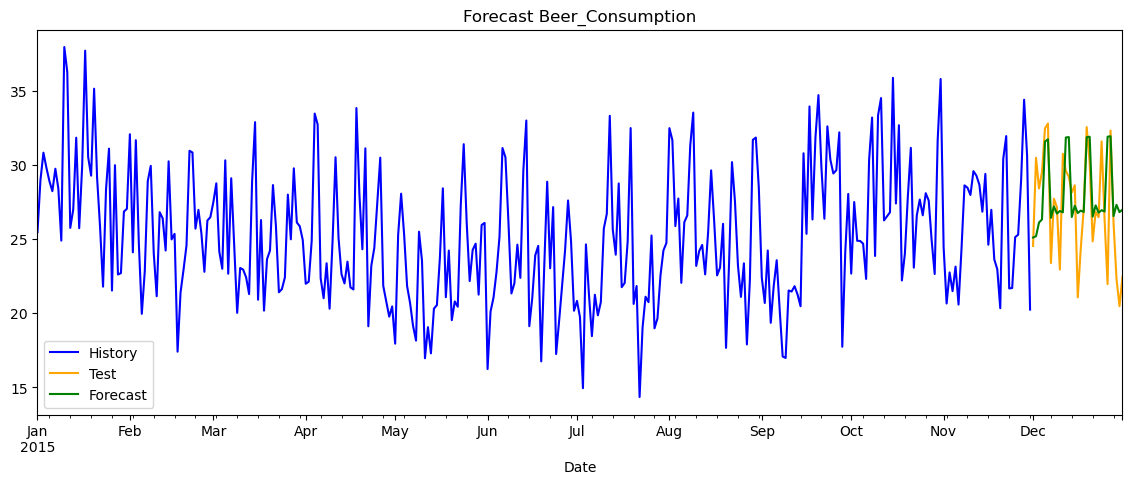

In [73]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history.plot(kind='line',x='Date' , y='Beer_Consumption', color='blue', label='History', ax=ax)
test.plot(kind='line', x='Date', y='Beer_Consumption', color='orange', label='Test', ax=ax)
pred.plot(kind='line', x='Date', y='predicted_mean', color='green', label='Forecast', ax=ax)
plt.title('Forecast Beer_Consumption')
plt.show()

In [75]:
mae = mean_absolute_error(test['Beer_Consumption'], pred['predicted_mean'])
mae

2.524976064065867

#### 2 In this question, you will acquainted with fitting data with SARIMAX

In [81]:
history

,Tempurature_Median,Weekend,Beer_Consumption,Date
Date,,,,
2015-01-01,27.30,0,25.461,2015-01-01
2015-01-02,27.02,0,28.972,2015-01-02
2015-01-03,24.82,1,30.814,2015-01-03
2015-01-04,23.98,1,29.799,2015-01-04
2015-01-05,23.82,0,28.900,2015-01-05
...,...,...,...,...
2015-11-26,22.28,0,25.285,2015-11-26
2015-11-27,22.28,0,28.979,2015-11-27
2015-11-28,23.70,1,34.382,2015-11-28


In [83]:
model=ARIMA(history['Beer_Consumption'], exog=history['Tempurature_Median'], order=(2,1,2), trend='t')
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:       Beer_Consumption   No. Observations:                  334
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -891.385
Date:                Thu, 30 Nov 2023   AIC                           1796.770
Time:                        11:21:49   BIC                           1823.427
Sample:                    01-01-2015   HQIC                          1807.400
                         - 11-30-2015                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
drift                  0.0054      0.003      1.768      0.077      -0.001       0.011
Tempurature_Median     0.7908      0.072     11.048      0.000       0.650       0.931
ar.L1               

In [84]:
pred = results.forecast(len(test),exog=test['Tempurature_Median'])
pred = pd.DataFrame(pred)

In [85]:
pred

,predicted_mean
2015-12-01,24.193724
2015-12-02,27.276948
2015-12-03,27.521883
2015-12-04,27.571321
2015-12-05,29.138610
2015-12-06,27.830098
2015-12-07,25.410705
2015-12-08,26.729718
2015-12-09,28.521097
2015-12-10,28.557729


In [86]:
mae = mean_absolute_error(test['Beer_Consumption'], pred['predicted_mean'])
mae

3.0556859510388414

#### 3 In this question, you will acquainted with fitting data with VAR

(a) Aggregate the data into quarterly data the same way as how I did it in L5. Split the data into the train (on or before the end of 2007) and the test (the rest data). Nothing to be submitted for this part.

In [6]:
import statsmodels.api as sm
macrodata = sm.datasets.macrodata.load_pandas().data
df=macrodata[["year","quarter","realgdp","realcons"]]
df.head()

,year,quarter,realgdp,realcons
0,1959.0,1.0,2710.349,1707.4
1,1959.0,2.0,2778.801,1733.7
2,1959.0,3.0,2775.488,1751.8
3,1959.0,4.0,2785.204,1753.7
4,1960.0,1.0,2847.699,1770.5


In [7]:
#define proper quaters
dates = df[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)

df=df[["realgdp","realcons"]]
df.index = pd.DatetimeIndex(quarterly)
df

,realgdp,realcons
1959-03-31,2710.349,1707.4
1959-06-30,2778.801,1733.7
1959-09-30,2775.488,1751.8
1959-12-31,2785.204,1753.7
1960-03-31,2847.699,1770.5
...,...,...
2008-09-30,13324.600,9267.7
2008-12-31,13141.920,9195.3
2009-03-31,12925.410,9209.2
2009-06-30,12901.504,9189.0


In [8]:
train = df[df.index <= pd.to_datetime('2008-01-01')]
test = df[df.index > pd.to_datetime('2008-01-01')]

In [22]:
len(test)

7

(b) Use the train data however you want to select and fit a VAR model and forecast the len(test). The key here is you need to difference the data manually to reach stationary, fit VAR on the stationary data, then reverse-difference to give the fore- cast of the original scale. The model should provide forecast for both "realgdp" and "realcons". Draw a plot with "train_realgdp", "train_realcons", "test_realgdp", "test_realcons", "test_realgdp_pred", "test_realcons_pred". Attach this plot as the an- swer of this question.

<Axes: >

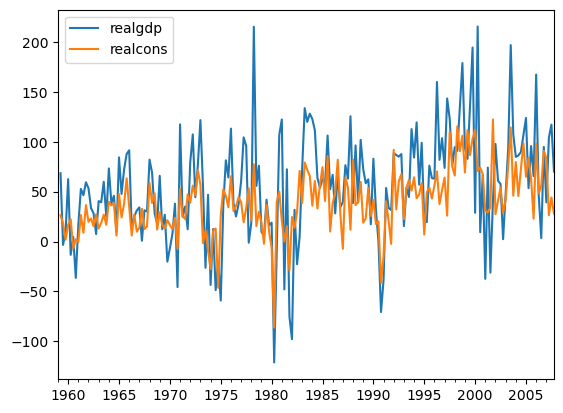

In [29]:
d1 = train.diff()
d1.plot()

In [30]:
# d1 = d1.dropna()
# adf_test(d1['realgdp'])
# adf_test(d1['realcons'])

<Axes: >

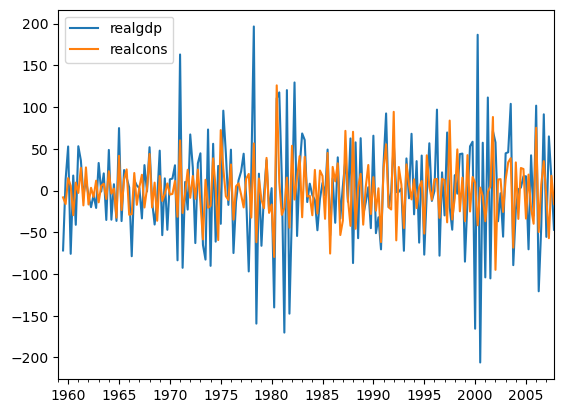

In [31]:
d2 = d1.diff()
d2.plot()

In [34]:
d2 = d2.dropna()
adf_test(d2['realgdp'])
adf_test(d2['realcons'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                -5.972493e+00
p-value                        1.921490e-07
#Lags Used                     1.400000e+01
Number of Observations Used    1.790000e+02
Critical Value (1%)           -3.467420e+00
Critical Value (5%)           -2.877826e+00
Critical Value (10%)          -2.575452e+00
dtype: float64
Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.785698e+01
p-value                        3.063799e-30
#Lags Used                     1.000000e+00
Number of Observations Used    1.920000e+02
Critical Value (1%)           -3.464875e+00
Critical Value (5%)           -2.876714e+00
Critical Value (10%)          -2.574859e+00
dtype: float64


In [12]:
from statsmodels.tsa.api import VAR

def train_test_eval(df, p, test_size):
    best_rmse, best_order = float("inf"), None
    train = df[:-test_size]
    test = df[-test_size:]
    for i in p:
        model = VAR(train)
        results = model.fit(i)
        predictions=results.forecast(y=train.values[-i:],steps=test_size)
        pred=pd.DataFrame(predictions)
        rmse = (np.sqrt(skmetrics.mean_squared_error(test[test.columns[0]], pred[pred.columns[0]]))+np.sqrt(skmetrics.mean_squared_error(test[test.columns[1]], pred[pred.columns[1]])))/2
        if rmse< best_rmse:
            best_rmse, best_order = rmse, i
        print('VAR%s RMSE=%.3f' % (i,rmse))
    print('Best VAR%s RMSE=%.3f' % (best_order, best_rmse))

In [35]:
train_test_eval(d2, p=range(1,6), test_size=len(test))

VAR1 RMSE=45.326
VAR2 RMSE=48.711
VAR3 RMSE=47.608
VAR4 RMSE=49.162
VAR5 RMSE=50.195
Best VAR1 RMSE=45.326


In [36]:
model = VAR(d2)
results = model.fit(1)
predictions=results.forecast(y=d2.values[-1:],steps=len(test))

In [37]:
predictions

array([[21.54823312,  9.64943127],
       [-8.42784693, -5.34130878],
       [ 3.47147247,  2.97538043],
       [-0.48395935, -1.44293506],
       [ 0.29394553,  0.80646364],
       [ 0.58913462, -0.28760571],
       [ 0.06883108,  0.21667155]])

In [38]:
df_forecast = pd.DataFrame(predictions,index=test.index,columns=['realgdp1D','realcons1D'])
df_forecast

,realgdp1D,realcons1D
2008-03-31,21.548233,9.649431
2008-06-30,-8.427847,-5.341309
2008-09-30,3.471472,2.975380
2008-12-31,-0.483959,-1.442935
2009-03-31,0.293946,0.806464
2009-06-30,0.589135,-0.287606
2009-09-30,0.068831,0.216672


In [39]:
nobs = len(test)
# df_forecast['realgdp1D'] = (df['realgdp'].iloc[-nobs-1] - df['realgdp'].iloc[-nobs-2]) + df_forecast['realgdp2D'].cumsum()
df_forecast['realgdpForcast'] = train['realgdp'].iloc[-1] + df_forecast['realgdp1D'].cumsum()

# df_forecast['realcons1D'] = (df['realcons'].iloc[-nobs-1]-df['realcons'].iloc[-nobs-2]) + df_forecast['realcons2D'].cumsum()
df_forecast['realconsForcast'] = train['realcons'].iloc[-1] + df_forecast['realcons1D'].cumsum()

In [40]:
df_forecast

,realgdp1D,realcons1D,realgdpForcast,realconsForcast
2008-03-31,21.548233,9.649431,13412.797233,9373.249431
2008-06-30,-8.427847,-5.341309,13404.369386,9367.908122
2008-09-30,3.471472,2.975380,13407.840859,9370.883503
2008-12-31,-0.483959,-1.442935,13407.356899,9369.440568
2009-03-31,0.293946,0.806464,13407.650845,9370.247031
2009-06-30,0.589135,-0.287606,13408.239979,9369.959426
2009-09-30,0.068831,0.216672,13408.308811,9370.176097


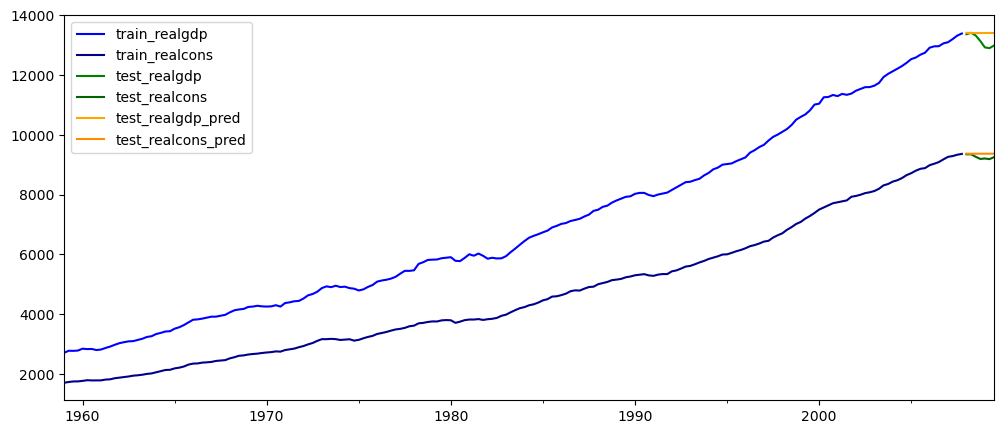

In [41]:
train['realgdp'].plot(figsize=(12,5),legend=True, color='blue', label='train_realgdp').autoscale(axis='x',tight=True)
train['realcons'].plot(figsize=(12,5),legend=True, color='darkblue', label='train_realcons').autoscale(axis='x',tight=True)

test['realgdp'].plot(figsize=(12,5),legend=True, color='green', label='test_realgdp').autoscale(axis='x',tight=True)
test['realcons'].plot(figsize=(12,5),legend=True, color='darkgreen', label='test_realcons').autoscale(axis='x',tight=True)

df_forecast['realgdpForcast'].plot(legend=True, color='orange', label='test_realgdp_pred');
df_forecast['realconsForcast'].plot(legend=True,color='darkorange',label='test_realcons_pred');